# Noise filtering a microscopic data #
## I. Noise description ##
Noise in microscopic image is unavoidable during image acquisition. There are three main categories of noise: 
1) <font color='magenta'>Photon noise</font>, also called fluorescence noise or shot noise: acquired due to the fluctuation of photon emission to the detector. This is the most dominant noise. It is signal dependent and follows a Poisson distribution. 
2) <font color='magenta'>Electronic noise</font>, also called dark current or dark noise: accumulated over time due to thermal change as the detector heats up. It is unavoidable but negligible compared to photon noise and is not photon dependent. It follows Poisson distribution. 
3) <font color='magenta'>Readout noise</font>: digital noise acquired during the electronic quantisation of photons. It follows a Gaussian distribution where the standard deviation is constant and the mean is 0.

Dominant noise in fluorescence microscopy follows either a Gaussian distribution or Poisson distribution or both. Gaussian noise is additive while Poisson noise is signal dependent. A correct removal of those two different types of noise may therefore differ. Firstly, we will look at how those noise affect the image differently. 

### I.1. Load image data ###

In [2]:
# LOAD PACKAGES
from scyjava import config          # for AICSImage
from aicsimageio import AICSImage   # for reading the image
import numpy as np                  # for operations on arrays
import matplotlib.pyplot as plt     # for plotting/display 
import cv2                          # for generating random noise with a given distribution

In [3]:
# LOAD DATA
mydata=AICSImage("C:/Users/Dina Ratsimandresy/Documents/MRC-Office/Dataset/PythonCourse precious images/Airy_4color_40nm_67e5micron_diversoformato-confocal.tif")
myimg = mydata.data[0,:,0,:,:]  # select all channels at t = 0 and z = 0
imgsize = myimg.shape           # image size

### I.2. Compare Gaussian and Poisson noise ###

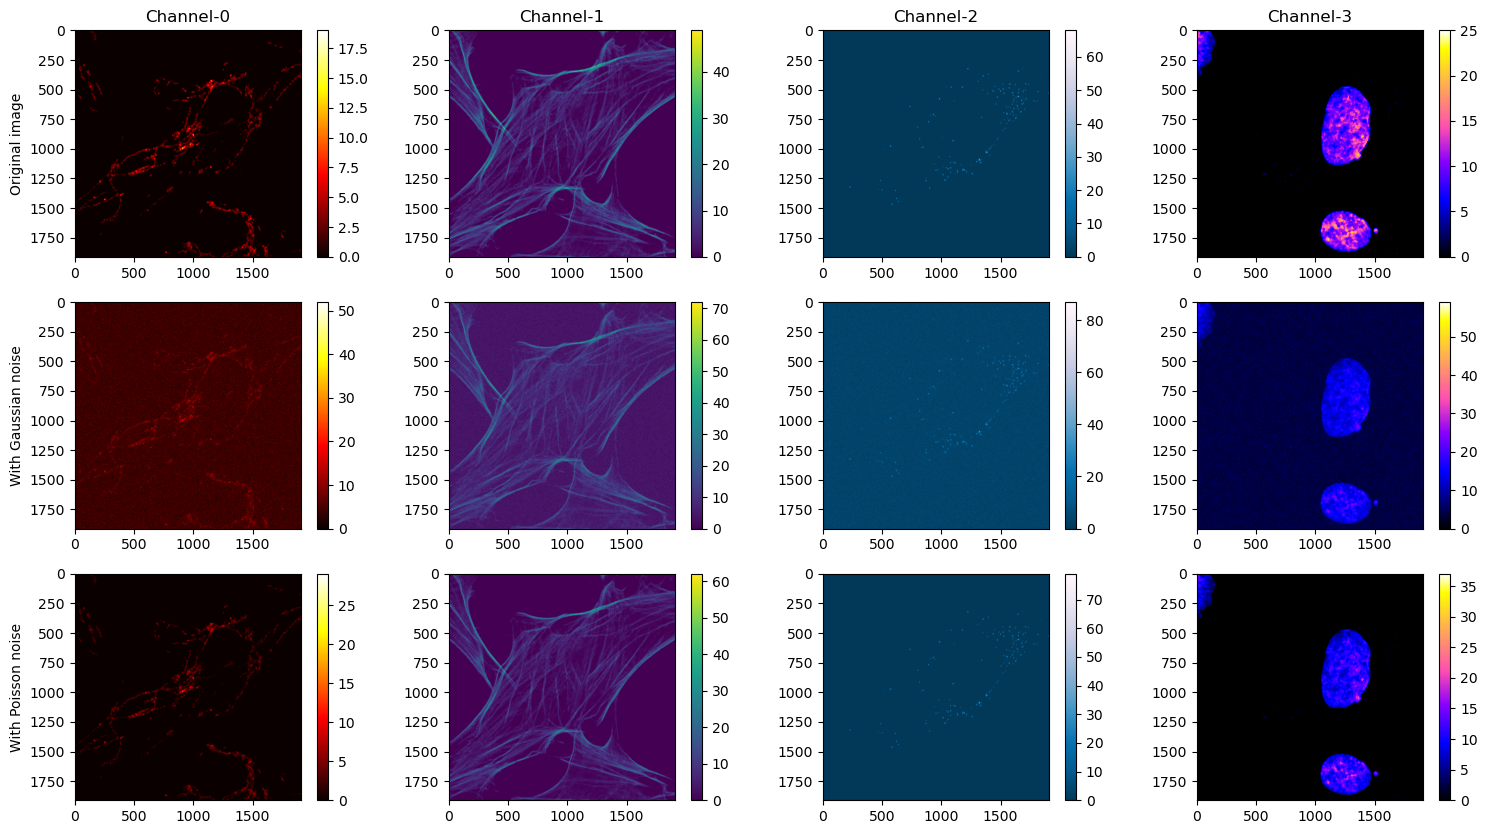

In [4]:
# DEFINE A COLORMAP FOR EACH CHANNEL
# cmplist=plt.colormaps() # This contains an extensive list of colormaps one can choose from
cmpsuggestion=['hot','viridis','PuBu_r','gnuplot2']

# ADD RANDOM GAUSSIAN NOISE
mean = 0
stddev = 10
noise = np.zeros(imgsize, np.uint8)
cv2.randn(noise, mean, stddev)
noisy_gauss_img = cv2.add(myimg, noise)

# APPLY POISSON NOISE
noisy_poisson_img = np.random.poisson(myimg)

# DISPLAY FOUR DIFFERENT CHANNELS
fig, axs = plt.subplots(3, 4)
for k in range(4):
    ax1=axs[0,k].imshow(myimg[k,:,:], plt.colormaps[cmpsuggestion[k]])              # original image
    ax2=axs[1,k].imshow(noisy_gauss_img[k,:,:], plt.colormaps[cmpsuggestion[k]])    # with addition Gaussian noise
    ax3=axs[2,k].imshow(noisy_poisson_img[k,:,:], plt.colormaps[cmpsuggestion[k]])  # after application of Poisson noise
    axs[0,k].set_title('Channel-'+str(k))
    plt.colorbar(ax1,ax=axs[0, k])
    plt.colorbar(ax2,ax=axs[1, k])
    plt.colorbar(ax3,ax=axs[2, k])
axs[0,0].set_ylabel('Original image')
axs[1,0].set_ylabel('With Gaussian noise')
axs[2,0].set_ylabel('With Poisson noise')

fig.set_size_inches(18.5, 10)

### I.3. Zoom over the images to have a better look of the difference ###

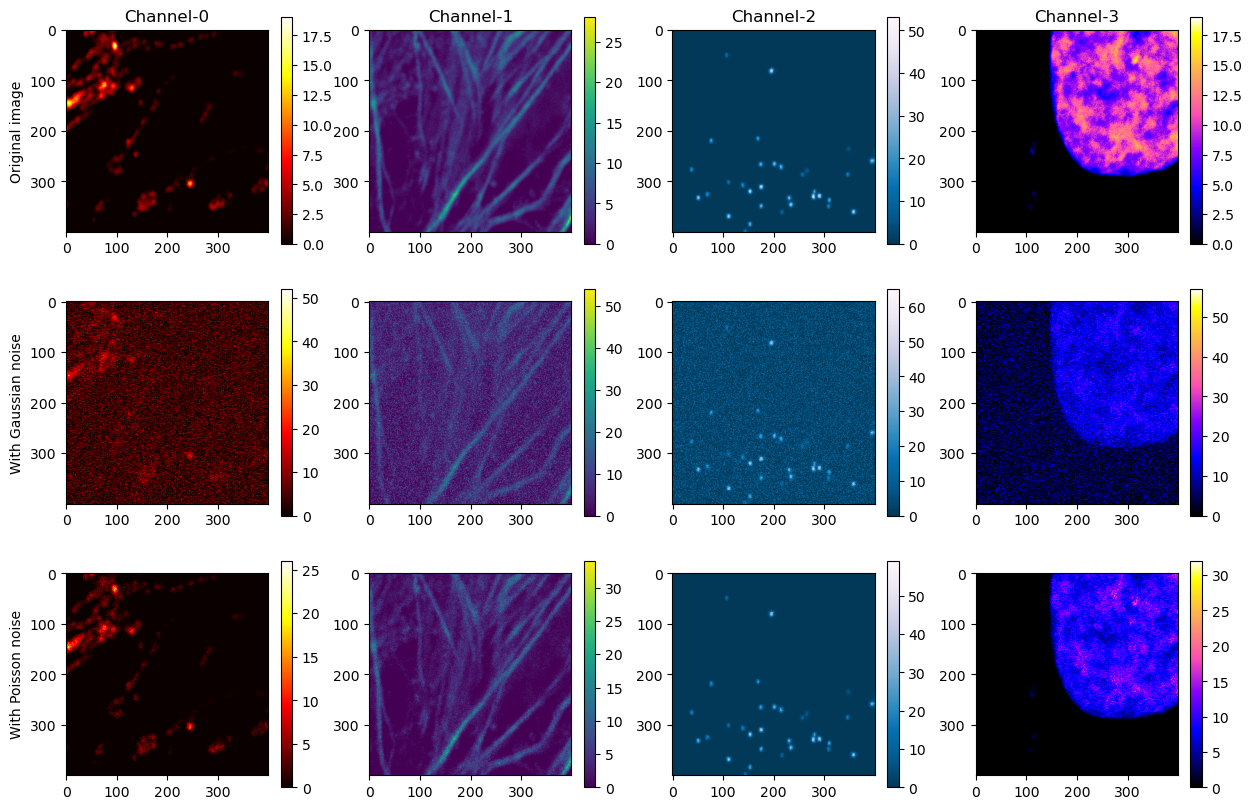

In [5]:
EdgeCoord = [850,1250,900,1300] # y-up, y-down, x-left, x-right 
myimgzoom = myimg[:,EdgeCoord[0]:EdgeCoord[1],EdgeCoord[2]:EdgeCoord[3]]
noisy_gauss_imgzoom = noisy_gauss_img[:,EdgeCoord[0]:EdgeCoord[1],EdgeCoord[2]:EdgeCoord[3]]
noisy_poisson_imgzoom = noisy_poisson_img[:,EdgeCoord[0]:EdgeCoord[1],EdgeCoord[2]:EdgeCoord[3]]

fig, axs = plt.subplots(3, 4)
for k in range(4):
    ax1=axs[0,k].imshow(myimgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])              # original image
    ax2=axs[1,k].imshow(noisy_gauss_imgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])    # with addition Gaussian noise
    ax3=axs[2,k].imshow(noisy_poisson_imgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])  # after application of Poisson noise
    axs[0,k].set_title('Channel-'+str(k))
    plt.colorbar(ax1,ax=axs[0, k])
    plt.colorbar(ax2,ax=axs[1, k])
    plt.colorbar(ax3,ax=axs[2, k])
axs[0,0].set_ylabel('Original image')
axs[1,0].set_ylabel('With Gaussian noise')
axs[2,0].set_ylabel('With Poisson noise')

fig.set_size_inches(15, 10)

## II. Noise filtering ##
There are different types of noise reduction: smoothing filtering or convolution filtering, mean filtering, median filtering, and frequency filtering. An image can be treated as a matrix, or array in Python. Each pixel has a value which represents the image intensity at the spatial position of the pixel. To filter an image, we need to work on each pixel of the image.

### II.1. Smoothing filtering ###
A smoothing filter uses the principle of convolution to reduce the noise. A convolution process is similar to drawing. The kernel is the pencil that is used for the drawing. So the sharpness of the drawn image really depends on the width of the point of the pencil. In the case of a Gaussian filtering, the Gaussian distribution is used as a kernel. When used for noise filterning, the noise which should have a lower intensity value than the real signal gets smoothed out because of this convolution process. Next, we will see below this process work.

In [6]:
# ILLUSTRATION OF THE CONVOLUTION PRINCIPLE OF AN OBJECT BY A GAUSSIAN DISTRIBUTION

# DRAW A SMILEY FACE
n = 255 # size of the smiley face
# left eye
a, b, r = 64, 100, 10 # (a,b) center position of left eye, r: eye radius
y,x = np.ogrid[-a:n-a, -b:n-b]
lefteye = x*x + y*y <= 10*10
# right eye
a, b, r = 64, 156, 10 # (a,b) center position of right eye, r: eye radius
y,x = np.ogrid[-a:n-a, -b:n-b]
righteye = x*x + y*y <= r*r
# nose
w=60 # width of the nose
m=np.ones((w,w))
a=np.diag(np.diag(m))
b=np.rot90(a)
nose=np.c_[ b, a ]  
c=np.ones((1,nose.shape[1]))
nose[-1]=c
# my smiley face
mysmileyface=np.zeros((n, n))
mysmileyface[128-int(w/2):128+int(w/2),128-w:128+w]=nose

mysmileyface=mysmileyface+lefteye+righteye

# COMPUTE A GAUSSIAN FUNCTION WITH A GIVEN FWHM
def gaus2d(n=255, mx=0, my=0, sx=1, sy=1):
    n2 = n/2
    x = np.linspace(-n2, n2,n)
    y = np.linspace(-n2, n2,n)
    x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

# CONVOLUTION AND DISPLAY
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual

def series(g_width_x, g_width_y):
    g = gaus2d(n,sx=g_width_x,sy=g_width_y) # Gaussian function which will be the filter
    blurface = signal.convolve2d(mysmileyface, g,mode='same')

    fig, ax0 = plt.subplots()
    ax0.imshow(mysmileyface,cmap='gray')
    ax0.set_title('Smiley face')

    fig, ax1 = plt.subplots()
    ax1.imshow(g,cmap='gray')
    ax1.set_title('Gaussian filter')

    fig, ax2 = plt.subplots()
    ax2.imshow(blurface,cmap='gray')
    ax2.set_title('Blurred smiley face')


    plt.show()


interact(series, g_width_x=(1,20,1),g_width_y=(1,20,1));




interactive(children=(IntSlider(value=10, description='g_width_x', max=20, min=1), IntSlider(value=10, descrip…

Now, let filter our noisy image with a Gaussian filter!

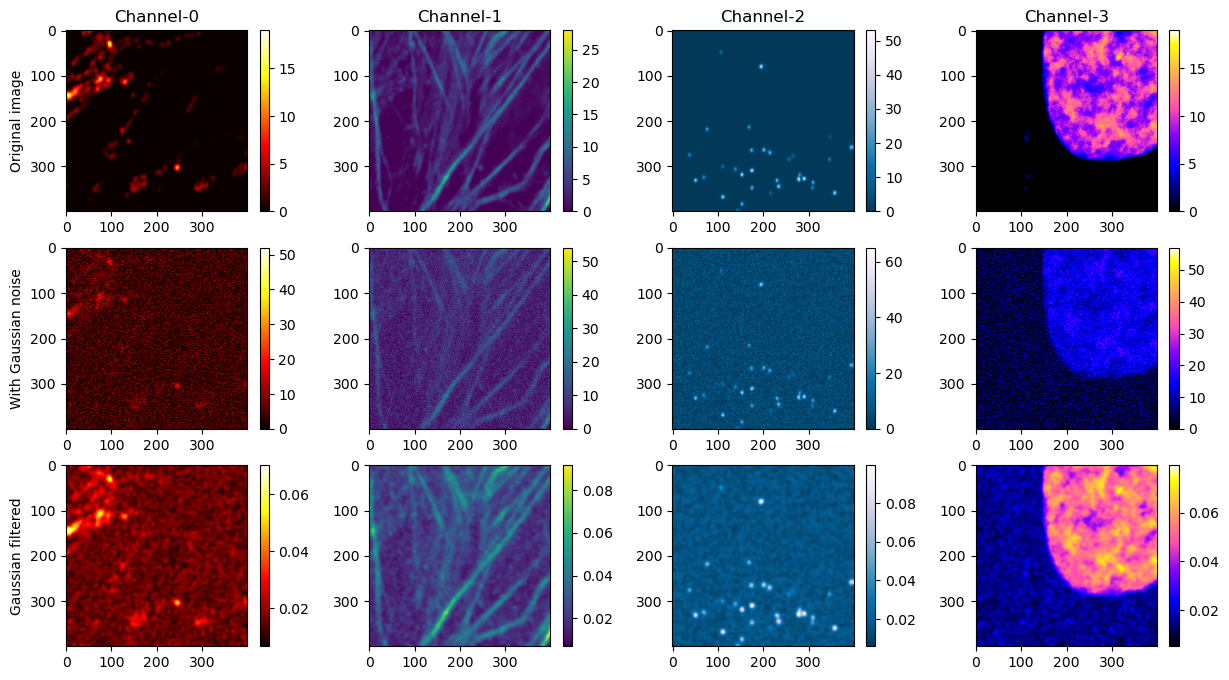

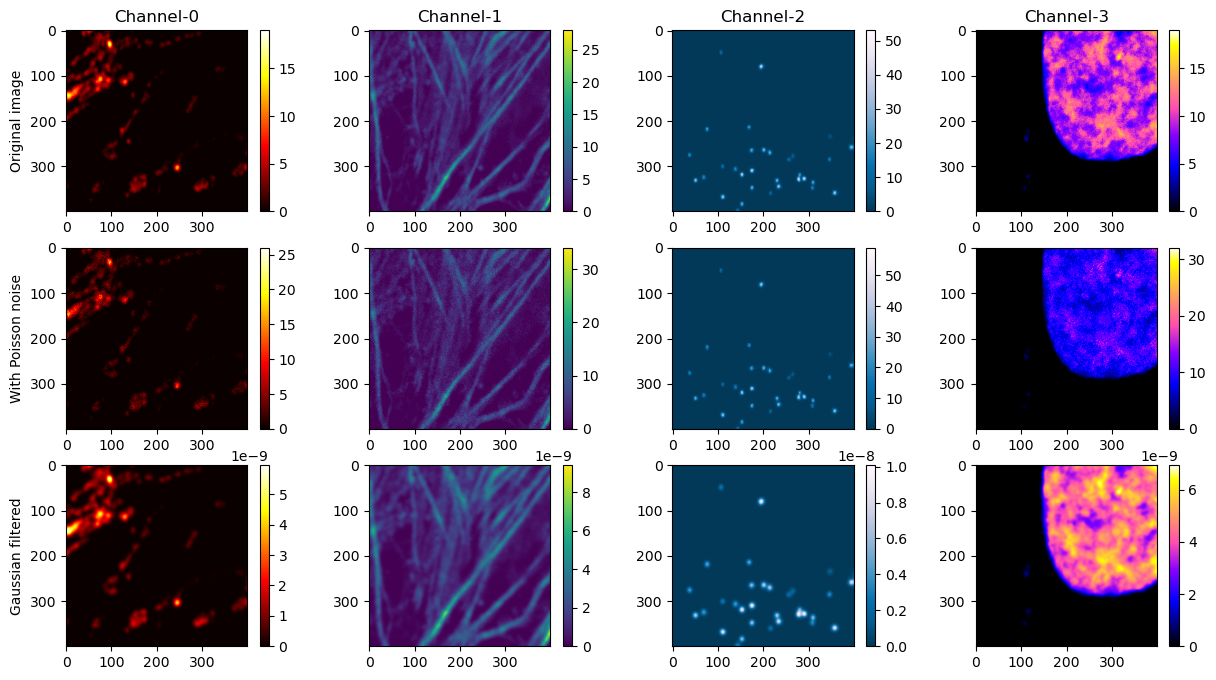

In [7]:
from skimage import filters
from skimage import restoration
sigmacyx=[0,3,3]
# myimg_gaussian_filtered=gaussian_filter(myimgzoom, sigma=sigmacyx)
noisy_gauss_gaussian_filtered=filters.gaussian(noisy_gauss_imgzoom, sigma=sigmacyx)
noisy_poisson_gaussian_filtered=filters.gaussian(noisy_poisson_imgzoom, sigma=sigmacyx)

# Gaussian filtering of data with Gaussian noise
fig, axs = plt.subplots(3, 4)
for k in range(4):
    ax1=axs[0,k].imshow(myimgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])              # original image
    ax2=axs[1,k].imshow(noisy_gauss_imgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])    # with addition Gaussian noise
    ax3=axs[2,k].imshow(noisy_gauss_gaussian_filtered[k,:,:], plt.colormaps[cmpsuggestion[k]])  # after application of Poisson noise
    axs[0,k].set_title('Channel-'+str(k))
    plt.colorbar(ax1,ax=axs[0, k])
    plt.colorbar(ax2,ax=axs[1, k])
    plt.colorbar(ax3,ax=axs[2, k])
axs[0,0].set_ylabel('Original image')
axs[1,0].set_ylabel('With Gaussian noise')
axs[2,0].set_ylabel('Gaussian filtered')

fig.set_size_inches(15, 8)

# Gaussian filtering of data with Poisson noise

fig, axs = plt.subplots(3, 4)
for k in range(4):
    ax1=axs[0,k].imshow(myimgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])              # original image
    ax2=axs[1,k].imshow(noisy_poisson_imgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]])    # with addition Gaussian noise
    ax3=axs[2,k].imshow(noisy_poisson_gaussian_filtered[k,:,:], plt.colormaps[cmpsuggestion[k]])  # after application of Poisson noise
    axs[0,k].set_title('Channel-'+str(k))
    plt.colorbar(ax1,ax=axs[0, k])
    plt.colorbar(ax2,ax=axs[1, k])
    plt.colorbar(ax3,ax=axs[2, k])
axs[0,0].set_ylabel('Original image')
axs[1,0].set_ylabel('With Poisson noise')
axs[2,0].set_ylabel('Gaussian filtered')

fig.set_size_inches(15, 8)

### III.2 Median and total variation filter ###
Different techniques for noise filtering are median and total variation (TV) filtering. With the median filter, each output pixel is computed as the median value of the input pixel under a chosen window. With TV filtering technique, the output image is an approximation of the input noisy image, which has a smaller total variation than the input image but is similar to the image. A total variation of an image measures how much the image changes between pixel values.

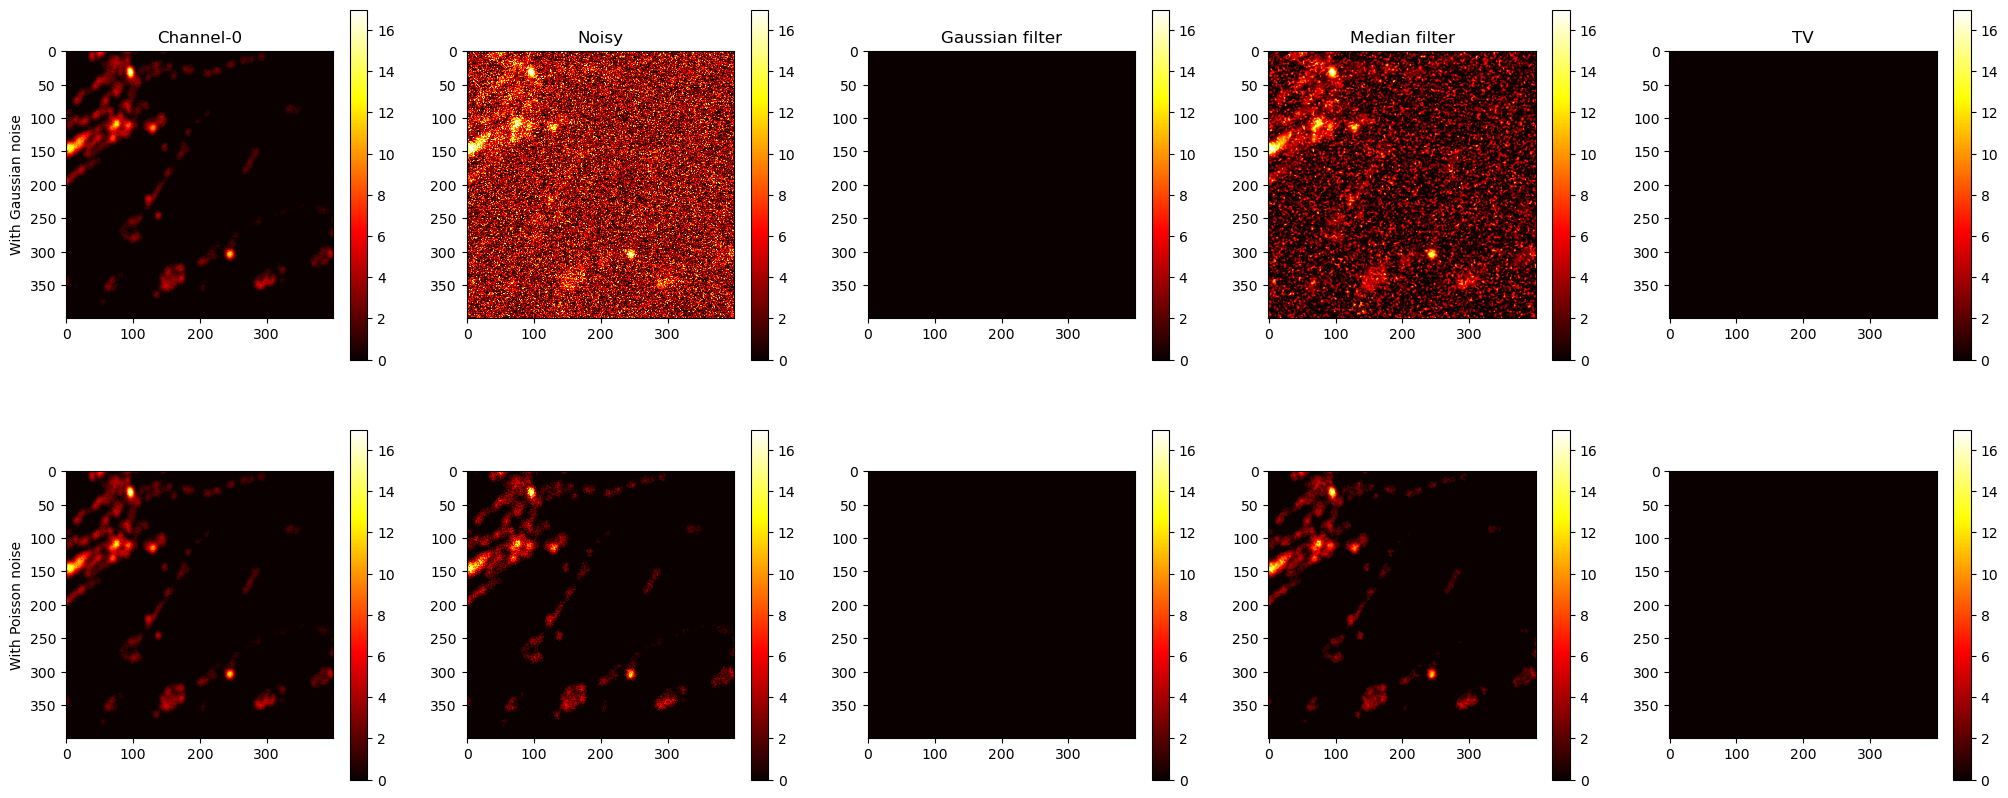

In [8]:
k = 0 # choose to display whichever channel you prefer [value between 0 and 3 for the particular data in this notebook]

# MEDIAN FILTERING
noisy_gauss_median_filtered=filters.median(noisy_gauss_imgzoom[k,:,:], np.ones((3,3))) # second argument in this function here defines the size of the Kernel over which the median is calculated
noisy_poisson_median_filtered=filters.median(noisy_poisson_imgzoom[k,:,:],  np.ones((3,3)))

# TOTAL VARIATION DENOISING
noisy_gauss_tv_filtered=restoration.denoise_tv_chambolle(noisy_gauss_imgzoom[k,:,:], weight=0.5)
noisy_poisson_tv_filtered=restoration.denoise_tv_chambolle(noisy_poisson_imgzoom[k,:,:], weight=0.5)

rangemin=0
rangemax=17

fig, axs = plt.subplots(2, 5)
ax1=axs[0,0].imshow(myimgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)              # original image
ax2=axs[0,1].imshow(noisy_gauss_imgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)    
ax3=axs[0,2].imshow(noisy_gauss_gaussian_filtered[k,:,:], plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)    
ax4=axs[0,3].imshow(noisy_gauss_median_filtered, plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)   
ax5=axs[0,4].imshow(noisy_gauss_tv_filtered, plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)  

ax6=axs[1,0].imshow(myimgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)              # original image
ax7=axs[1,1].imshow(noisy_poisson_imgzoom[k,:,:], plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)    
ax8=axs[1,2].imshow(noisy_poisson_gaussian_filtered[k,:,:], plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)    
ax9=axs[1,3].imshow(noisy_poisson_median_filtered, plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax)   
ax10=axs[1,4].imshow(noisy_poisson_tv_filtered, plt.colormaps[cmpsuggestion[k]], vmin =rangemin, vmax=rangemax) 

listtilt=['Channel-'+str(k), 'Noisy', 'Gaussian filter', 'Median filter', 'TV']
listaxup=[ax1,ax2,ax3,ax4,ax5]
listaxdown=[ax6,ax7,ax8,ax9,ax10]

for i in range(5):
    axs[0,i].set_title(listtilt[i])
    plt.colorbar(listaxup[i],ax=axs[0, i])
    plt.colorbar(listaxdown[i],ax=axs[1, i])

axs[0,0].set_ylabel('With Gaussian noise')
axs[1,0].set_ylabel('With Poisson noise')

fig.set_size_inches(25, 10)
